/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F850LPcand e_F850LPcand (240): hst/ACS_update_sep07/wfc_f850lp_t81.dat
f_F125W e_F125W (

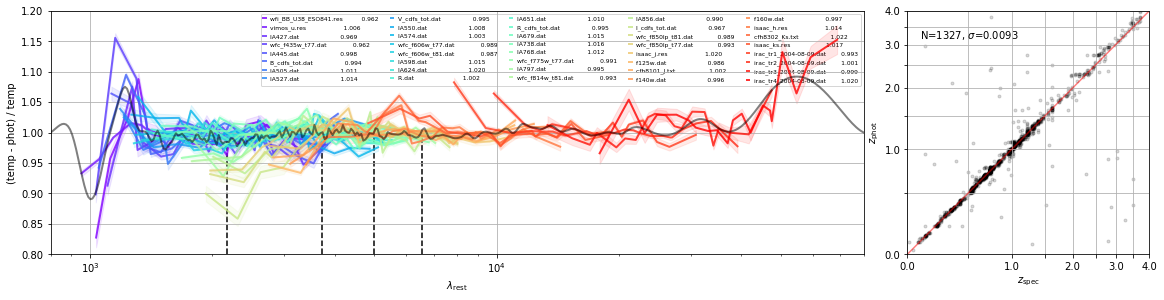

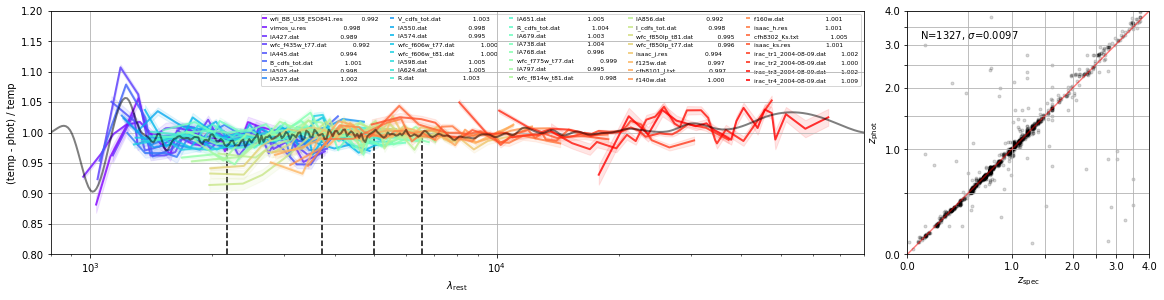

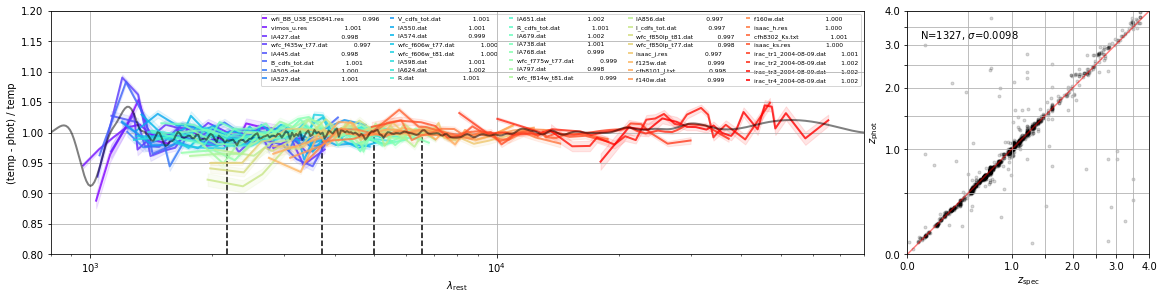

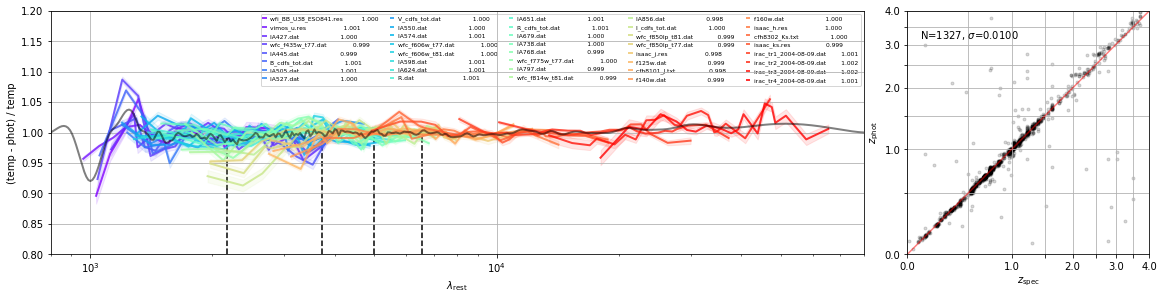

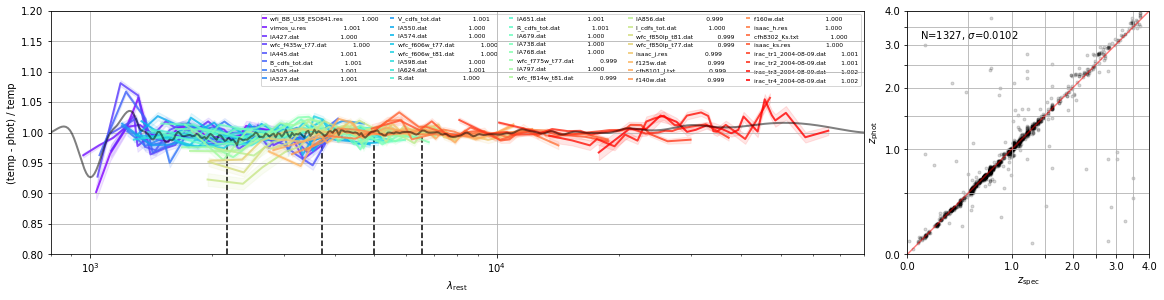

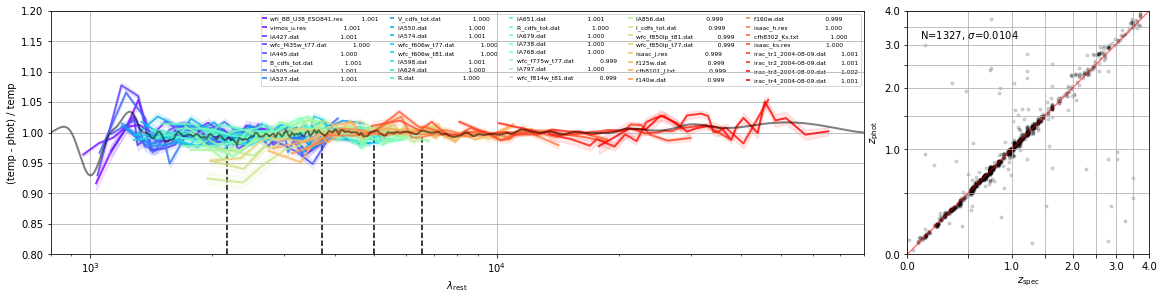

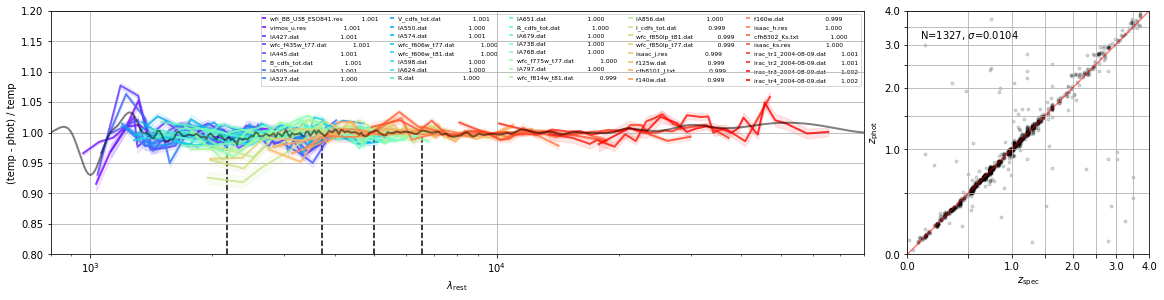

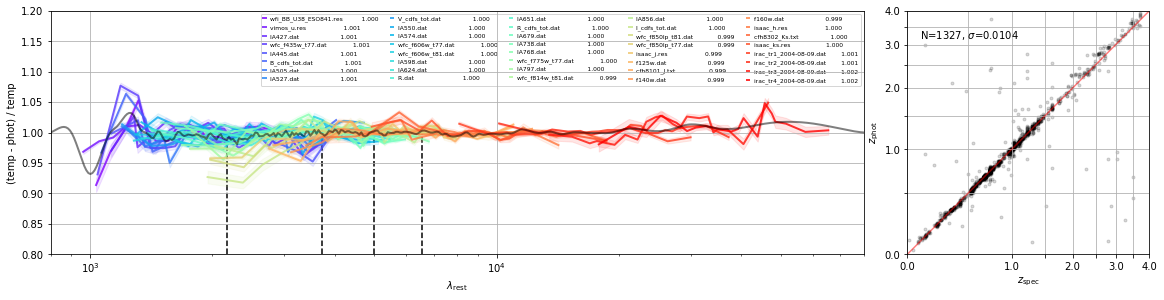

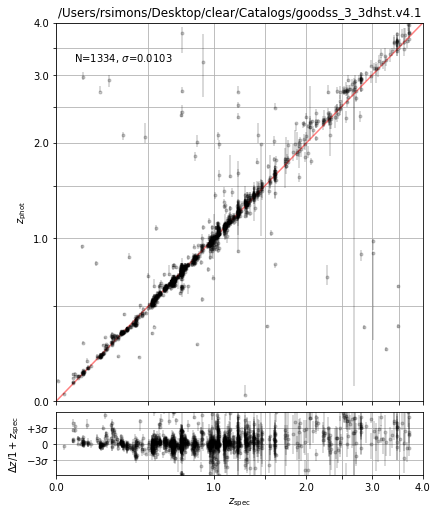

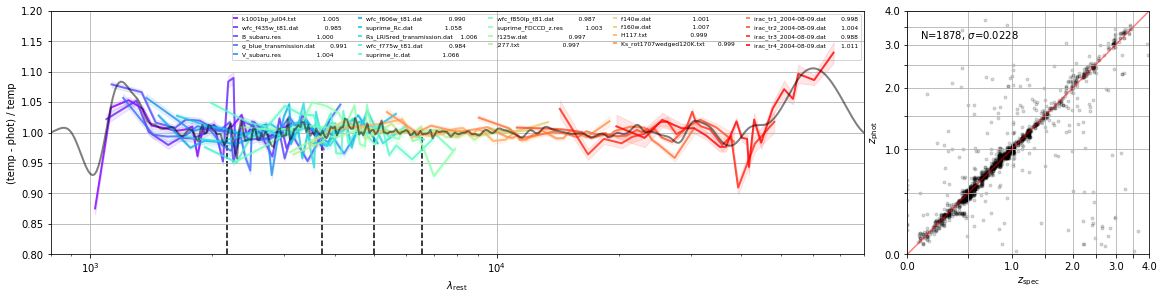

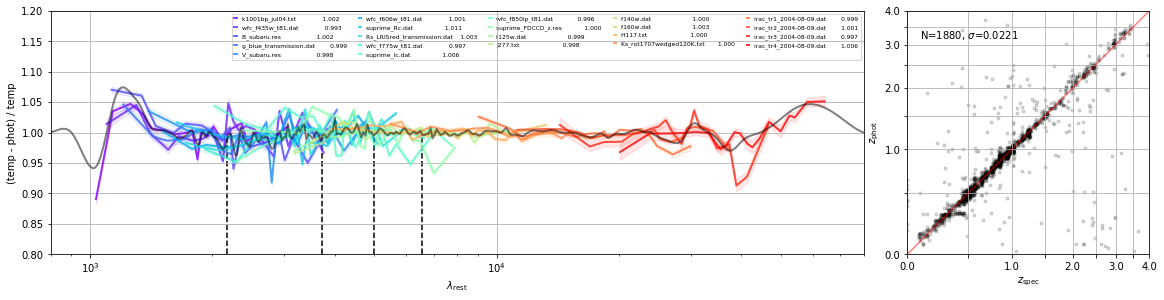

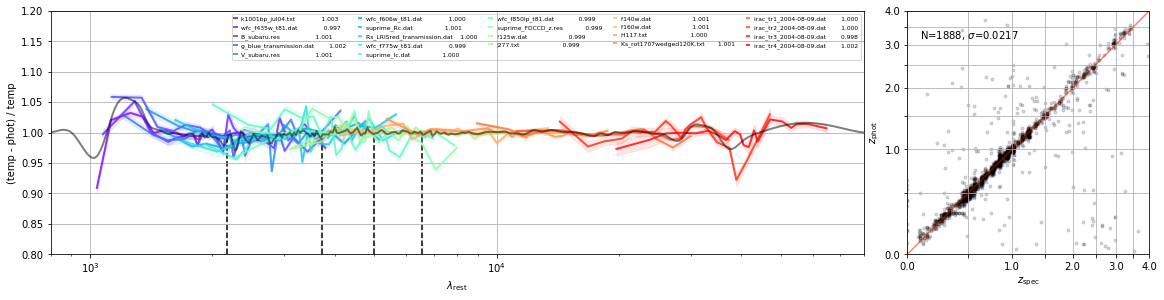

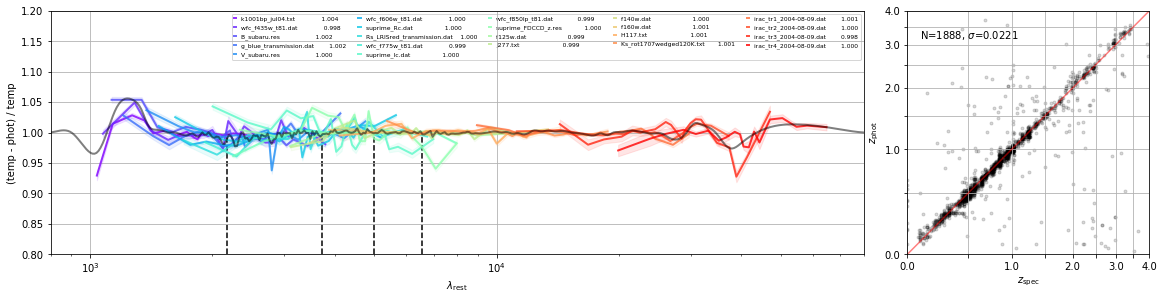

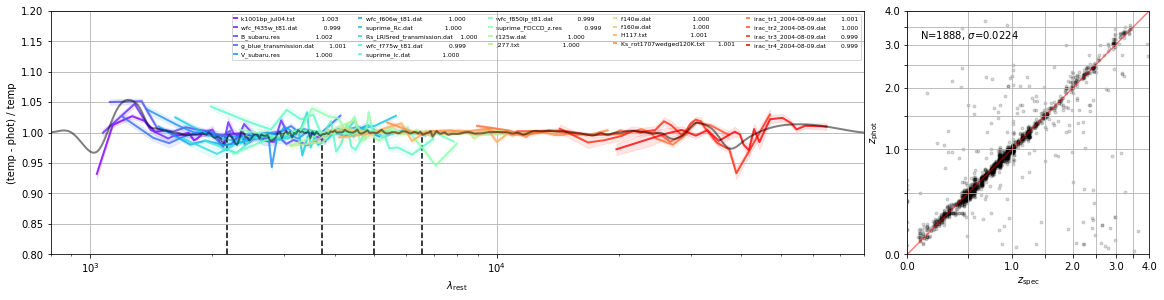

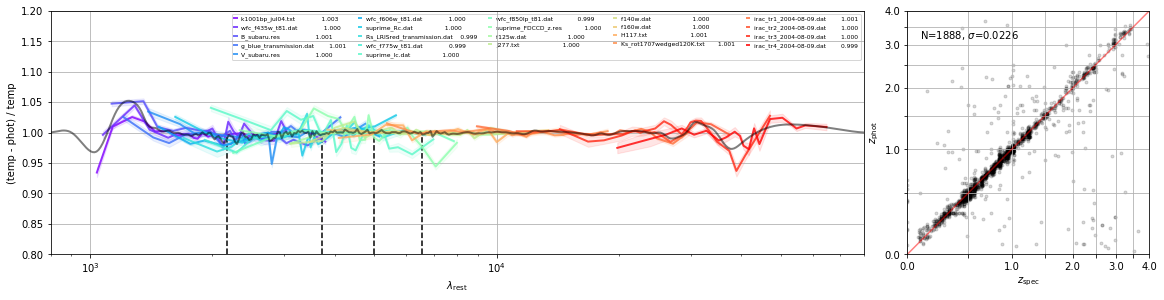

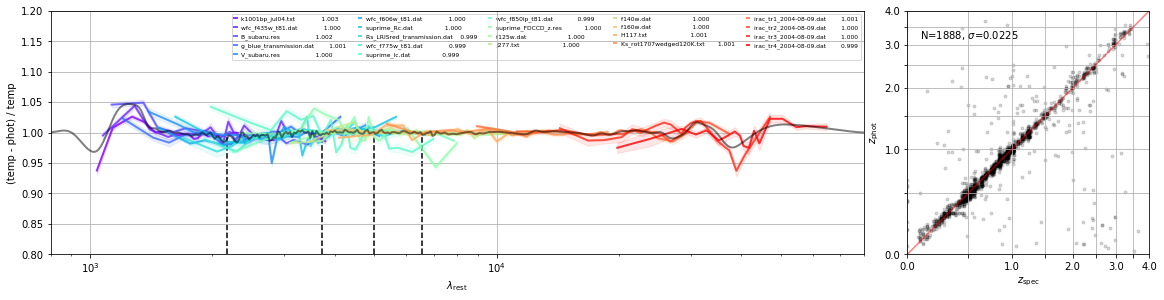

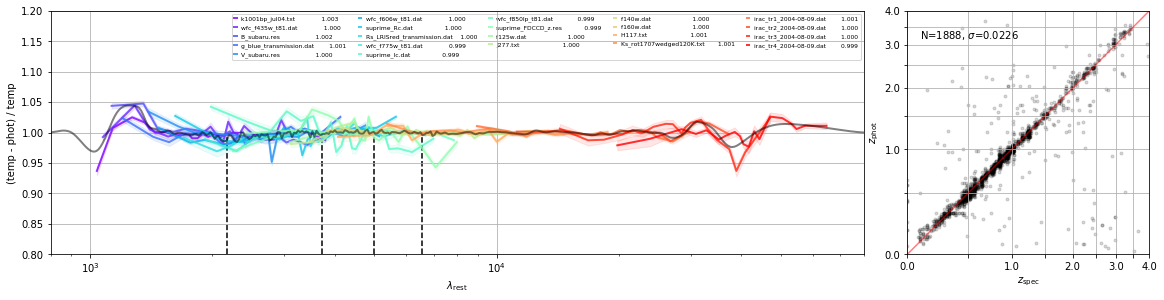

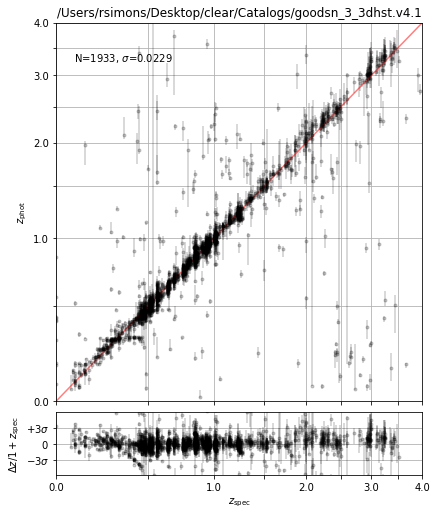

In [4]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
import eazy
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning) 
#eazy.symlink_eazy_inputs()

eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', path_is_env=False)

field = 'goodss'
n = 0


for n in arange(3,4):
    for field in ['goodss', 'goodsn']:
        params = {}
        if n == 0:
            params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst.v4.1.cats/Catalog/%s_3dhst.v4.1.cat'%(field, field)
            params['TEMP_ERR_FILE'] = 'templates/TEMPLATE_ERROR.eazy_v1.0'
            params['WAVELENGTH_FILE'] = 'templates/lambda_v1.1.def'
            params['TEMPLATES_FILE'] = 'templates/tweak_cosmos_v4_spectra.param'
            params['PRIOR_FILE'] = 'templates/prior_K_zmax7.dat'
            if field == 'goodss': params['PRIOR_FILTER'] = 37
            elif field == 'goodsn': params['PRIOR_FILTER'] = 226
        if n == 1:
            params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst_temp.v4.3.cat'%field
            params['PRIOR_FILE'] = 'templates/prior_F160W_TAO.dat'
        if n == 2:
            params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst.v4.1.cats/Catalog/%s_3dhst.v4.1.cat'%(field, field)
            params['PRIOR_FILE'] = 'templates/prior_F160W_TAO.dat'

        if n == 3:
            params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst.v4.1.cats/Catalog/%s_3dhst.v4.1.cat'%(field, field)
            params['PRIOR_FILE'] = 'templates/prior_F160W_TAO.dat'
            params['APPLY_IGM'] = 'n'


        params['MAIN_OUTPUT_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_%i_3dhst.v4.1'%(field, n)

        # Galactic extinction
        params['MW_EBV'] = 0.0103
        params['Z_STEP'] = 0.01
        params['Z_MIN'] = 0.01
        params['Z_MAX'] = 6.
        params['PRIOR_ABZP'] = 25.000
        params['TEMP_ERR_A2'] = 0.500
        params['SYS_ERR'] = 0.02
        params['FIX_ZSPEC'] = False        
        translate_file = '/Users/rsimons/Desktop/clear/Catalogs/%s_v4.3.translate'%field
        self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
                                  params=params, load_prior=True, load_products=False)
        
        
        NITER = 8
        NBIN = np.minimum(self.NOBJ//100, 180)

        self.param.params['VERBOSITY'] = 1.
        for iter in range(NITER):
            print('Iteration: ', iter)
            sn = self.fnu/self.efnu
            clip = (sn > 10).sum(axis=1) > 10 # Generally make this higher to ensure reasonable fits
            print(len(np.where(clip == True)[0]))
            self.iterate_zp_templates(idx=self.idx[clip], update_templates=False, 
                                      update_zeropoints=True, iter=iter, n_proc=8, 
                                      save_templates=False, error_residuals=(iter > 0), 
                                      NBIN=NBIN, get_spatial_offset=False)
        
        
        # Turn off error corrections derived above
        self.efnu = self.efnu_orig*1

        # Full catalog
        sample = np.isfinite(self.cat['z_spec'])
        self.fit_parallel(self.idx[sample], n_proc=8)
        # Show zspec-zphot comparison
        fig = self.zphot_zspec()
        fig.savefig('/Users/rsimons/Desktop/clear/figures/%s_%i_zpec_zphot.png'%(field, n), dpi = 300)
        self.write_zeropoint_file(file = '/Users/rsimons/Desktop/clear/Catalogs/%s_%i_tc_nzp_v4.4.zeropoint'%(field, n))


In [5]:
self.param.params

OrderedDict([('VERBOSITY', 1.0),
             ('FILTERS_RES', 'FILTER.RES.latest'),
             ('FILTER_FORMAT', 1.0),
             ('SMOOTH_FILTERS', 'n'),
             ('SMOOTH_SIGMA', 100.0),
             ('TEMPLATES_FILE',
              'templates/fsps_full/tweak_fsps_QSF_12_v3.param'),
             ('TEMPLATE_COMBOS', 'a'),
             ('NMF_TOLERANCE', 0.0001),
             ('WAVELENGTH_FILE', 'templates/uvista_nmf/lambda.def'),
             ('TEMP_ERR_FILE', 'templates/uvista_nmf/template_error_10.def'),
             ('TEMP_ERR_A2', 0.5),
             ('SYS_ERR', 0.02),
             ('APPLY_IGM', 'n'),
             ('SCALE_2175_BUMP', 0.0),
             ('MW_EBV', 0.0103),
             ('CAT_HAS_EXTCORR', 'y'),
             ('DUMP_TEMPLATE_CACHE', 'n'),
             ('USE_TEMPLATE_CACHE', 'n'),
             ('CACHE_FILE', 'photz.tempfilt'),
             ('CATALOG_FILE',
              '/Users/rsimons/Desktop/clear/Catalogs/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat')

In [3]:
n

3